In [1]:
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys # max float
import numpy as np
import sympy as sp
from sympy.plotting import plot
from sympy.plotting import plot3d
import matplotlib.pyplot as plt
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from dqn_agent_NEW import Agent
import gym
from gym.spaces import Box, Discrete, MultiDiscrete

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [3]:
## parameter/ constant
bandwidth = 1e6  # [hz]
Speed_of_light = 3e8  # [m/s]
Carrier_freq = 2e9  # [hz]=1/s
GBS_location = [0,0,20] #[m] 20
Num_GBS = 1
# NUM_User = 10
NUM_UAV = 2
Cell_Radius = 1000 #[m]
UAV_Height = 100#100 #[m] "Cell-Edge User Offloading via Flying UAV in Non-Uniform Heterogeneous Cellular Networks," in IEEE Transactions on Wireless Communications, vol. 19, no. 4, pp. 2411-2426, April 2020, doi: 10.1109/TWC.2020.2964656.
P_UAV = 10 **(37 / 10) / 1000 #[watt] 
P_GBS = 10 **(40 / 10) / 1000 #[watt]
P_MAX = 0.4 # 26dbm, user
# P_MIN = 0.1 # 20 dbm
epsilon = 0.38 # power amplifier efficiency
AWGN_DBM = -174 #[dBm]
AWGN_W = 10 ** (AWGN_DBM / 10) / 1000
air_density = 1.225 # Air density at sea level (kg/m³)
g = 9.81            # Gravitational acceleration (m/s²)
mass = 0.5           # Mass of UAV in kg
radius = 0.2         # Rotor radius in meters
num_rotors = 4
P_MOVE =10 #[watt]
V = 20 # m/s


In [4]:
def init_uav_positions(NUM_UAV, UAV_Height, random_position):

    UAV_2D = [random_position() for _ in range(NUM_UAV)]
    UAV_positions = []
    
    for i in range(NUM_UAV):
        temp_list = list(UAV_2D[i])
        temp_list[2] = UAV_Height
        updated_tuple = tuple(temp_list)
        # print(temp_list)
        UAV_positions.append(updated_tuple)
    
    return UAV_positions

In [5]:
# Fixed location User
User_position = [
(653.8316581607805, -590.3141344883956, 0),
 (655.7839795019095, 511.39715579708627, 0),
 (-366.9200930533958, -378.53106855942656, 0),
 (774.0710077290566, -813.74371579118, 0),
 (-902.1513920204236, 689.4058695488745, 0),
 (-887.8742394199635, 629.5122712145035, 0),
 (-480.4469889568361, -411.7900064526441, 0),
 (-584.0565231366488, -207.29087777276175, 0),
 (917.8907259745158, -388.6065319450123, 0),
 (482.22239122176074, 382.7717524589923, 0),
 (75.08205947,	-246.6113445,	0),
(89.08034796,	93.40797308	,0),
(539.8534823,	-160.3015493,	0),
(139.7089773,	716.6716587	,0),
(-569.3566777,	263.1666404	,0),
(-90.29446879,	-288.6084637	,0),
(-767.5899487,	-135.3924119,	0),
(773.8435759	,-235.8694596	,0),
(613.2944812	,608.7494777	,0),
(204.2851089	,-171.0078052	,0),
# (386.1443989	,-926.5117843	,0),
# (-938.0904915	,99.43896713	,0),
# (-937.1604717,	-444.6725165	,0),
# (694.8819289	,668.5820704	,0),
# (834.6212365	,987.1367586,	0),
# (348.2927666	,-81.11493568	,0),
# (-955.8690815	,81.17473736	,0),
# (-545.2280657	,977.3220921	,0),
# (-700.3981729	,-579.959419	,0),
# (653.7133739	,-669.164471	,0),
]

In [6]:
NUM_User = len(User_position)
NUM_User

20

In [7]:
#Calculate Distance
def distance(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
D_n_bs = np.zeros((NUM_UAV + Num_GBS, NUM_User))

In [8]:
#pathloss, unitless
def gain_n(distance):
    c = Speed_of_light
    f= Carrier_freq
    pi = np.pi
    return (c/(4*pi*f*distance))**(2)

In [9]:
#Generte link selection
def generate_matrix_and_assign_users(rows=3, cols=10):
    while True:
        matrix_selection = np.zeros((rows, cols), dtype=int)
        for col in range(cols):
            row_idx = np.random.randint(0, rows)
            matrix_selection[row_idx, col] = 1
        
        # Calculate row sums
        tmp = np.sum(matrix_selection, axis=1)
        if tmp[0] > 0 and tmp[1] > 0:
            break
    
    # Determine user assignments based on the matrix
    UAV1_user = np.argwhere(matrix_selection[0] == 1).T[0].tolist()
    UAV2_user = np.argwhere(matrix_selection[1] == 1).T[0].tolist()
    GBS_user = np.argwhere(matrix_selection[2] == 1).T[0].tolist()
    
    return matrix_selection, UAV1_user, UAV2_user, GBS_user
matrix_selection, UAV1_user, UAV2_user, GBS_user = generate_matrix_and_assign_users()

# generate selectionn not yet set constraint
import random
rows = 3
cols = 10
while True:
    matrix_selection = np.zeros((rows, cols), dtype=int) # matrix
    for col in range(cols):
        row_idx = np.random.randint(0, rows)
        matrix_selection[row_idx, col] = 1
    tmp = np.sum(matrix_selection, axis=1)
    # print(tmp[0])
    if tmp[0] > 0 and tmp[1] > 0:
        break
UAV1_user = np.argwhere(matrix_selection[0] == 1).T[0].tolist()
UAV2_user = np.argwhere(matrix_selection[1] == 1).T[0].tolist()
GBS_user = np.argwhere(matrix_selection[2] == 1).T[0].tolist()

In [10]:
P_MIN = 0.001
P_MAX = P_UAV
P_MAX_user = P_MAX/NUM_User

In [11]:
p_u1_level = np.random.uniform(P_MIN, P_MAX, len(UAV1_user))
p_u1_normalize = p_u1_level / np.sum(p_u1_level) * P_MAX
power_sort = sorted(p_u1_normalize)
# SINR
def noma_sinr(channel_conditions, selected_users, powers, transmitter_id):
    if not selected_users:
        return [], []
    
    gains = [channel_conditions[transmitter_id, user] for user in selected_users]
    # Sort users by channel gain (strongest first)
    sorted_indices = np.argsort(gains)[::-1]  # Descending order
    sorted_users = [selected_users[i] for i in sorted_indices]
    sorted_gains = [gains[i] for i in sorted_indices]
    sinrs = []
    for i, user in enumerate(sorted_indices):
        interference = 0
        sinr = (powers[user] * sorted_gains[user]) / (AWGN_W + interference)
        sinrs.append(sinr)
    
    return sinrs, selected_users
sinrs = noma_sinr(gain_n(D_n_bs), UAV1_user, power_sort, 0)

c:\Users\Sothearath\anaconda3\envs\python3_7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [12]:
#Data rate
num_user = NUM_User
sorted_users = sinrs[1]
sorted_users_sinr = sinrs[0]
def calculate_transmission_rate(sinr, num_user):
    """Calculate achievable rate using Shannon capacity"""
    if num_user == 0:
        num_user = 1
    # print("bandwidth",int(bandwidth))
    # print("bandwidth for users",int(bandwidth/num_user))
    return (int(bandwidth/num_user) * np.log2(1 + sinr))/1e6 # MHz

rate_n = calculate_transmission_rate(np.array(sorted_users_sinr), 1)

In [13]:
# # 10 user
# traffic_data = np.array([ 8.795845 ,  4.476116 ,  5.5037837,  6.0243654, 12.920729 ,
#         5.5970373,  6.0550256,  4.872516 ,  7.577386 ,  9.967498 ])
# # #15 user
# traffic_data = np.array([14.2345, 4.7710037, 7.6004195, 7.6562877, 22.904835, 10.31743,
#                          10.02901, 10.140568, 13.525869, 17.060368, 20.13406, 3.3490102, 
#                          17.419847, 15.829944, 6.5886827 ])
# 20 user
traffic_data = np.array([15.045018, 6.545699, 7.0056453, 7.0192256, 26.408241, 9.260441, 
                         10.931942, 8.048492, 12.15611, 15.898077, 19.099787, 4.9521737,
                           17.933542, 14.467922, 9.955734, 13.156038, 21.471113, 10.216565, 8.602531, 17.791065])

# #25 user
# traffic_data = np.array([14.101378, 6.327937, 6.9734707, 7.705143, 24.17083, 8.45224, 10.937698,
#                           7.165816, 13.620338, 16.299187, 21.602406, 4.3687615, 18.788303, 16.177567, 
#                           8.267505, 15.565486, 23.637806, 11.268315, 8.559526, 16.202307, 17.567959, 23.138298, 
#                           19.848198, 4.852388, 10.035355])

# # 30 user
# traffic_data = np.array([13.730608, 5.326337, 6.305037, 8.3221855, 24.156334, 9.056003, 11.426689, 11.308687, 
#                          13.707179, 16.739891, 22.561272, 4.2011957, 16.53558, 13.905987, 4.317765, 14.405717, 
#                          23.871864, 11.336344, 9.031543, 19.897724, 16.41292, 19.279444, 18.578587, 5.886368, 8.510113,
#                            8.288387, 10.033254, 18.78224, 12.353946, 24.130177])

In [14]:
# Find max Rate
max_band_ratio = 1
distance_min = 100 #meter
P_MAX_user =  P_UAV/NUM_User #0.5011872336272725 
max_gain = gain_n(distance_min)
max_sinr = ( P_MAX_user* max_gain) / (AWGN_W )
max_rate = (max_band_ratio * bandwidth) * np.log2(1 + max_sinr)/1e6 # MHz
max_rate

39.70611888041109

In [15]:
# Calculate Energy consumption
num_tslot = 24
time_slots = np.arange(0, num_tslot)
def calculate_com_energy(time_slot,p_tx, data_tx, data_rate):
   
    opt_time = data_tx / data_rate 
    
    # energy_hov = (hover_power * max(opt_time))  # Watt-s
    energy_com = (p_tx * opt_time)           # Watt-s
    # print(data_tx, data_rate)
    # print("energy_sum [watt/s]",energy_com/3600) # convert to watt-hour
    return energy_com ,0 #energy_hov

In [16]:
action_raw = np.array([-0.75872153, -0.52341117 ,-0.30280006 , 0.06692477  ,0.3536657 , -0.62184727
  ,0.13012949 , 0.88997036, -0.13342942  ,0.07663916 , 0.88196602 , 0.43026105,
 -0.15862031 , 0.46067098 , 0.758543   ,-0.58921435 ,-0.19666775 , 0.99088893,
 -0.04939915 ,-0.82172018 ,-0.30306248 , 0.97151314 ,-0.59759432, -0.39876553,-0.75872153, -0.52341117 ,-0.30280006 , 0.06692477  ,0.3536657 , -0.62184727
  ,0.13012949 , 0.88997036, -0.13342942  ,0.07663916 , 0.88196602 , 0.43026105,
 -0.15862031 , 0.46067098 , 0.758543   ,-0.58921435 ,-0.19666775 , 0.99088893,
 -0.04939915 ,-0.82172018 ,-0.30306248 , 0.97151314 ,-0.59759432, -0.39876553,-0.04939915 ,-0.82172018 ,-0.30306248 , 0.97151314 ,-0.59759432, -0.39876553,
   -0.75872153, -0.52341117 ,-0.30280006 , 0.06692477  ,0.3536657 , -0.62184727
  ,0.13012949 , 0.88997036, -0.13342942  ,0.07663916 , 0.88196602 , 0.43026105,
 -0.15862031 , 0.46067098 , 0.758543   ,-0.58921435 ,-0.19666775 , 0.99088893,
 -0.04939915 ,-0.82172018 ,-0.30306248 , 0.97151314 ,-0.59759432, -0.39876553,-0.75872153, -0.52341117 ,-0.30280006 , 0.06692477  ,0.3536657 , -0.62184727
  ,0.13012949 , 0.88997036, -0.13342942  ,0.07663916 , 0.88196602 , 0.43026105,
 -0.15862031 , 0.46067098 , 0.758543   ,-0.58921435 ,-0.19666775 , 0.99088893,
 -0.04939915 ,-0.82172018 ,-0.30306248 , 0.97151314 ,-0.59759432, -0.39876553,-0.04939915 ,-0.82172018 ,-0.30306248 , 0.97151314 ,-0.59759432,])
len(action_raw)

107

In [17]:
# constrain power
def control_power_allocation(powers, max_power):
    """Ensure power allocations don't exceed maximum power"""
    total_power = np.sum(powers)
    
    if total_power > max_power:
        # Scale all powers proportionally
        scale_factor = max_power / total_power
        return powers * scale_factor
    
    return powers

In [18]:
# Scale UAV: Objective function 
request_rate = traffic_data
def object_function_DQN(action):
    
    power_level =np.array([(action[i]) for i in range(NUM_User)])
    power_alloc = control_power_allocation(power_level,P_UAV)
    
    uav_locations = np.array([(action[i]) for i in range(NUM_User, NUM_User + 2 * NUM_UAV)])
    uav_positions = uav_locations.reshape(NUM_UAV, 2)  # Reshape into (NUM_UAV, 2) -> (x, y) pairs
    end_index = min(NUM_User + 2 * NUM_UAV + NUM_User, len(action))

    link_values = action[NUM_User + 2 * NUM_UAV : end_index]
    link_uavs = {uav_idx: [] for uav_idx in range(NUM_UAV)}
    link_bs = []
    MAX_CONNECTIONS = 5
    uav_connection_counts = {uav_idx: 0 for uav_idx in range(NUM_UAV)}
    bs_connection_count = 0

    # Process links with connection limit
    for i, value in enumerate(link_values):
        for uav_idx in range(NUM_UAV):
            if uav_idx <= value < (uav_idx + 1):  
                link_uavs[uav_idx].append(i)
                break
        
        if value >= NUM_UAV:  # User connects to the base station
            # Check if the base station has reached its connection limit
            if bs_connection_count < MAX_CONNECTIONS:
                link_bs.append(i)
                bs_connection_count += 1
            else:
                # Base station is full, find the UAV with the lowest user count
                min_users_uav = min(uav_connection_counts, key=uav_connection_counts.get)
                link_uavs[min_users_uav].append(i)
    # print(f"link_bs:{link_bs}")  
    #         
    powers = power_alloc
    p_user_uavs = {uav_idx: powers[link_uavs[uav_idx]] for uav_idx in range(NUM_UAV)}
    
    link_lists = [link_uavs[i] for i in range(NUM_UAV)]
    p_user_lists = [p_user_uavs[i][0:len(link_lists[i])] for i in range(NUM_UAV)]
    p_user_bs = powers[link_bs]

    for uav_id in range(NUM_UAV):
        x_uav, y_uav = uav_positions[uav_id]
        for j in range(NUM_User):
            user_pos = User_position[j]
            D_n_bs[uav_id][j] = distance(x1=x_uav, y1=y_uav, z1=UAV_Height, x2=user_pos[0], y2=user_pos[1], z2=user_pos[2])

    for j in range(NUM_User):
        user_pos = User_position[j]
        D_n_bs[NUM_UAV][j] = distance(x1=GBS_location[0], y1=GBS_location[1], z1=GBS_location[2], x2=user_pos[0], y2=user_pos[1], z2=user_pos[2])

    channel_gains = gain_n(D_n_bs)
    
    sinr_uavs = [noma_sinr(channel_gains, link_lists[i], p_user_lists[i], i) for i in range(NUM_UAV)]
    sinr_bs = noma_sinr(channel_gains, link_bs, p_user_bs, NUM_UAV)
    rate_mbps_uavs = [calculate_transmission_rate(np.array(sinr_uavs[i][0]), len(link_lists[i])) for i in range(NUM_UAV)]
    rate_mbps_bs = calculate_transmission_rate(np.array(sinr_bs[0]), len(link_bs))
    # sum_rate = sum([np.sum(rate) for rate in rate_mbps_uavs]) + np.sum(rate_mbps_bs)
    requested_rates_uavs = [request_rate[sinr_uavs[i][1]] for i in range(NUM_UAV)]
    energy_uavs = [calculate_com_energy(time_slots[0], p_user_lists[i], requested_rates_uavs[i], rate_mbps_uavs[i]) if link_lists[i] else ([0], [0]) for i in range(NUM_UAV)]
    
    energy_com_uavs = [energy_uavs[i][0] for i in range(NUM_UAV)]
    energy_hov_uavs = [0 for _ in range(NUM_UAV)]
    energy_mov_uavs = [0.00 for _ in range(NUM_UAV)]
    
    sum_energy_uavs = [energy_mov_uavs[i] + np.sum(energy_com_uavs[i]) + energy_hov_uavs[i] for i in range(NUM_UAV)]
    sum_energy = sum(sum_energy_uavs)
    check_minrate = [*rate_mbps_bs] + [rate for sublist in rate_mbps_uavs for rate in sublist]
    UAV_energy = sum_energy_uavs

    avg_rate = np.mean(check_minrate)
    avg_energy = sum_energy / NUM_UAV
    max_energy = P_MAX_user * 5
    rate_normalize = avg_rate * (1 / int(max_rate))
    energy_normalize = - (avg_energy / max_energy)
    result_obj_normalize = (0.5*rate_normalize) +  (0.5*energy_normalize) #- penalty
    return result_obj_normalize , avg_rate, avg_energy
    
object_function_DQN(action_raw)


(-3.516330589650964, 3.504292668709663, 8.924283769656954)

In [19]:
np.random.randint(0, NUM_UAV + Num_GBS)

0

In [20]:
# # ======================= Environment ============================

class UAVEnv:
    def __init__(self, action_space_size,
                 initial_noise_std=0.2, noise_decay=0.995, min_noise_std=0.01):
        self.P_MIN = P_MIN
        self.P_MAX_user = P_MAX_user
        self.NUM_User = NUM_User
        self.NUM_UAV = NUM_UAV
        self.Num_GBS = Num_GBS
        self.action_space_size = action_space_size
        self.state_dim = (self.Num_GBS + self.NUM_UAV) * self.NUM_User + self.NUM_User

        # Noise scheduling
        self.noise_std = initial_noise_std
        self.initial_noise_std = initial_noise_std
        self.noise_decay = noise_decay
        self.min_noise_std = min_noise_std

        self.reset()

    def reset(self):
        self.state = np.array(np.vstack([gain_n(D_n_bs), request_rate]).flatten())
        return self.state

    def step(self, action_idx):
        action = self.decode_action(action_idx, add_noise=True)
        reward, avg_rate, avg_energy = object_function_DQN(action)
        next_state = np.array(np.vstack([gain_n(D_n_bs), request_rate]).flatten())
        done = False
        return next_state, reward, done, {"avg_rate": avg_rate, "avg_energy": avg_energy}

    def decode_action(self, action_idx, add_noise=False):
        action = np.zeros(self.NUM_User + 2 * self.NUM_UAV + self.NUM_User)

        # Reproducible deterministic lookup (custom hash from action_idx)
        rng = np.random.RandomState(action_idx)  # to ensure deterministic, same idx will return same action anytime

        # User transmit powers
        power_options = np.linspace(self.P_MIN, self.P_MAX_user, 500)
        for i in range(self.NUM_User):
            action[i] = power_options[rng.randint(len(power_options))]

        # UAV positions
        axis_options = np.linspace(-1000, 1000, 50000)
        for i in range(self.NUM_UAV):
            action[self.NUM_User + 2 * i] = axis_options[rng.randint(len(axis_options))]   # x
            action[self.NUM_User + 2 * i + 1] = axis_options[rng.randint(len(axis_options))]  # y

        # User association
        for i in range(self.NUM_User):
            action[self.NUM_User + 2 * self.NUM_UAV + i] = rng.randint(0, self.NUM_UAV + Num_GBS)  # {0,...,NUM_UAV}

        # # Add Gaussian noise (only to continuous parts: power and position)
        # if add_noise:
        #     noise_power = np.random.normal(0, self.noise_std, size=self.NUM_User)
        #     noise_position = np.random.normal(0, self.noise_std * 500, size=2 * self.NUM_UAV)

        #     # Apply and clip noise
        #     action[:self.NUM_User] += noise_power
        #     action[:self.NUM_User] = np.clip(action[:self.NUM_User], self.P_MIN, self.P_MAX_user)

        #     pos_start = self.NUM_User
        #     pos_end = self.NUM_User + 2 * self.NUM_UAV
        #     action[pos_start:pos_end] += noise_position
        #     action[pos_start:pos_end] = np.clip(action[pos_start:pos_end], -1000, 1000)

        return action

    def decay_noise(self):
        self.noise_std = max(self.noise_std * self.noise_decay, self.min_noise_std)


In [22]:

# ======================= Training Loop ============================
def train():
    env = UAVEnv(action_space_size = 2 * NUM_User + 2 * NUM_UAV)  # dummy size
    state_dim = env.state_dim
    action_dim = env.action_space_size
    epsilon = 0.9           # initial exploration rate
    epsilon_min = 0.01      # final exploration rate
    epsilon_decay = 0.995   # decay per episode

    agent = Agent(state_dim, action_dim, seed=1234)
    n_episode = 1000
    EP_REWARD = []
    EP_RATE = []
    EP_ENERGY = []
    for episode in range(n_episode):
        state = env.reset()
        total_reward = 0
        
        T_RATE = []
        T_ENERGY = []
        T_REWARD = []
        for t in range(50):
            action = agent.act(state, eps=epsilon)
            next_state, reward, done, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            # Store experience
            # agent.memory.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            if done:
                    break
            T_REWARD.append(np.mean(reward))
            T_RATE.append(np.mean(info["avg_rate"]))
            T_ENERGY.append(np.mean(info["avg_energy"]))
        EP_REWARD.append(np.mean(T_REWARD))
        EP_RATE.append(np.mean(T_RATE))
        EP_ENERGY.append(np.mean(T_ENERGY))
        
        # Decay epsilon after each episode
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        if episode % 10 == 0:
            print(f"Episode {episode}, Total_Reward: {total_reward:.2f}, Reward: {reward:.2f}, AVG_RATE:{info['avg_rate']:.2f},AVG_ENERGY:{info['avg_energy']:2f},Epsilon: {epsilon:.2f}")
    return EP_REWARD, EP_RATE, EP_ENERGY
if __name__ == "__main__":
    EP_REWARD, EP_RATE, EP_ENERGY = train()

Episode 0, Total_Reward: -64.37, Reward: -0.90, AVG_RATE:4.77,AVG_ENERGY:2.403568,Epsilon: 0.90
Episode 10, Total_Reward: -59.19, Reward: -0.74, AVG_RATE:4.68,AVG_ENERGY:2.007832,Epsilon: 0.85
Episode 20, Total_Reward: -61.59, Reward: -1.28, AVG_RATE:4.80,AVG_ENERGY:3.353807,Epsilon: 0.81
Episode 30, Total_Reward: -59.36, Reward: -1.12, AVG_RATE:4.79,AVG_ENERGY:2.965167,Epsilon: 0.77
Episode 40, Total_Reward: -54.84, Reward: -1.16, AVG_RATE:4.87,AVG_ENERGY:3.065037,Epsilon: 0.73
Episode 50, Total_Reward: -57.94, Reward: -0.74, AVG_RATE:4.68,AVG_ENERGY:2.007832,Epsilon: 0.70
Episode 60, Total_Reward: -52.35, Reward: -1.26, AVG_RATE:4.91,AVG_ENERGY:3.312283,Epsilon: 0.66
Episode 70, Total_Reward: -54.76, Reward: -0.74, AVG_RATE:4.68,AVG_ENERGY:2.007832,Epsilon: 0.63
Episode 80, Total_Reward: -54.65, Reward: -0.74, AVG_RATE:4.68,AVG_ENERGY:2.007832,Epsilon: 0.60
Episode 90, Total_Reward: -50.78, Reward: -1.18, AVG_RATE:4.77,AVG_ENERGY:3.102930,Epsilon: 0.57
Episode 100, Total_Reward: -56.

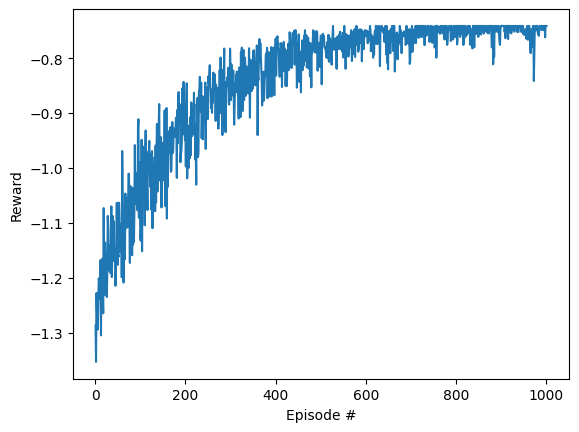

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(EP_REWARD)+1), EP_REWARD)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.show()

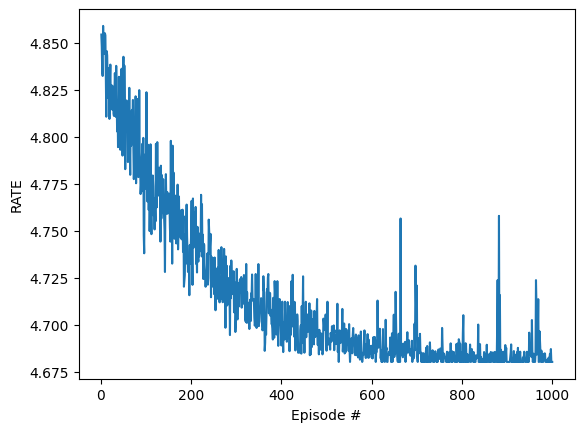

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(EP_RATE)+1), EP_RATE)
plt.ylabel('RATE')
plt.xlabel('Episode #')
plt.show()

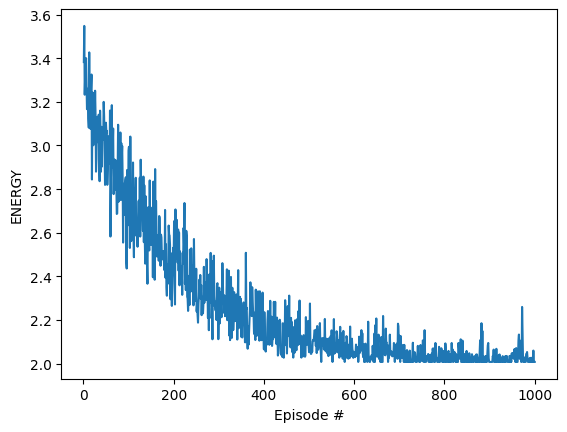

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(EP_ENERGY)+1), EP_ENERGY)
plt.ylabel('ENERGY')
plt.xlabel('Episode #')
plt.show()